In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
import torchvision.models as models
import numpy as np
import torchvision
from torch.optim import SGD
from sklearn.model_selection import KFold
import torch.nn.functional as F
import os

In [2]:
#checking for device
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
#Transforms
transformer=transforms.Compose([
    transforms.Resize((150,150)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
    transforms.Normalize([0.5,0.5,0.5], # 0-1 to [-1,1] , formula (x-mean)/std
                        [0.5,0.5,0.5])
])

In [4]:
# Define the size of the image grid
grid_size = 150

# Initialize an empty tensor to store distances
r2 = torch.zeros(grid_size * grid_size)

# Compute distances for each pixel
for i in range(grid_size):
    for j in range(grid_size):
        r2[grid_size * i + j] = ((74.5 - i) ** 2 + (74.5 - j) ** 2)

# Verify the size of dis
print("Size of dis tensor:", r2.size())

# Find the maximum value in the r2 tensor
max_r2 = r2.max()
normalized_r2 = r2/max_r2

# Move r2 tensor to CUDA if available
normalized_r2 = normalized_r2.cuda()

Size of dis tensor: torch.Size([22500])


In [5]:
class LensClassifier(nn.Module):
    def __init__(self,normalized_r2):
        super(LensClassifier, self).__init__()
        self.normalized_r2 = normalized_r2
        
    # Step 2: Use another ResNet-18 for vector A
        self.resnet_A = models.resnet18(pretrained=True)
        
#         for param in self.resnet_B.parameters():  # Freeze ResNet-18 parameters
#             param.requires_grad = False
            
        self.features_A = nn.Sequential(*list(self.resnet_A.children())[:-2])
        self.features_A.add_module('flatten', nn.Flatten())
        self.features_A.add_module('dropout', nn.Dropout(p=0.4))  # Adding dropout layer
        self.relu = nn.ReLU(inplace=True)
        self.features_A.add_module('linear', nn.Linear(12800, 22500))
        
    # Step 3: Use another ResNet-18 for vector B
        self.resnet_B = models.resnet18(pretrained=True)
        
#         for param in self.resnet_B.parameters():  # Freeze ResNet-18 parameters
#             param.requires_grad = False
            
        self.features_B = nn.Sequential(*list(self.resnet_B.children())[:-2])
        self.features_B.add_module('flatten', nn.Flatten())
        self.features_B.add_module('dropout', nn.Dropout(p=0.4))  # Adding dropout layer
#         self.relu = nn.ReLU(inplace=True)
        self.features_B.add_module('linear', nn.Linear(12800, 22500))
        
        # Step 5: Neural layer and softmax
        
        self.neural_layer1 = nn.Linear(22500,5625 )
        self.neural_layer2 = nn.Linear(5625, 128)
        self.neural_layer3 = nn.Linear(128, 3)
        self.dropout = nn.Dropout(p=0.4)  # Adding dropout layer
        #self.softmax = nn.Softmax(dim=1)

    def forward(self, x):

        # Step 2: Extract features A
    
        features_A = self.features_A(x)
        features_A = self.relu(features_A)
        features_A = features_A.view(features_A.size(0), -1)
        
        # Step 3: Extract features B
    
        features_B = self.features_B(x)
        features_B = self.relu(features_B)
        features_B = features_B.view(features_B.size(0), -1)
        
        # Step 4: Physics equation C = I - B * (distance from center of image) (treated as constant)
        C = features_A - features_B * (self.normalized_r2)
        
        # Step 5: Neural layer and softmax
        output = self.neural_layer1(C)
        output = self.relu(output)
        output = self.dropout(output)
        
        output = self.neural_layer2(output)
        output = self.relu(output)
        output = self.dropout(output) # Applying dropout
        
        output = self.neural_layer3(output)
        #output = self.softmax(output)
        
        return output

In [6]:
# Initialize the LensClassifier with fixed I and normalized_r2
model = LensClassifier(normalized_r2)
model.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 149MB/s] 


LensClassifier(
  (resnet_A): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

In [7]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [8]:
from torchsummary import summary
summary(model, (3, 150, 150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 75, 75]           9,408
            Conv2d-2           [-1, 64, 75, 75]           9,408
       BatchNorm2d-3           [-1, 64, 75, 75]             128
       BatchNorm2d-4           [-1, 64, 75, 75]             128
              ReLU-5           [-1, 64, 75, 75]               0
              ReLU-6           [-1, 64, 75, 75]               0
         MaxPool2d-7           [-1, 64, 38, 38]               0
         MaxPool2d-8           [-1, 64, 38, 38]               0
            Conv2d-9           [-1, 64, 38, 38]          36,864
           Conv2d-10           [-1, 64, 38, 38]          36,864
      BatchNorm2d-11           [-1, 64, 38, 38]             128
      BatchNorm2d-12           [-1, 64, 38, 38]             128
             ReLU-13           [-1, 64, 38, 38]               0
             ReLU-14           [-1, 64,

In [9]:
from torch.optim.lr_scheduler import StepLR

In [10]:
# Define RAdam optimizer
optimizer = SGD(model.parameters(), lr=0.01, weight_decay=0.0001)
# Define BCE loss function
loss_function = nn.CrossEntropyLoss()
# Define the scheduler
scheduler = StepLR(optimizer, step_size=5, gamma=0.1, verbose=True)

Adjusting learning rate of group 0 to 1.0000e-02.


In [11]:
# Define number of epochs and folds
num_epochs = 5
num_folds = 5

In [12]:
# Path for training directory
train_path = '/kaggle/input/k-fold-train/png_dataset/train'

In [13]:
class_folders = torchvision.datasets.ImageFolder(train_path,transform=transformer)

In [14]:
from torch.utils.data import Subset

In [16]:
# Initialize best accuracy
best_accuracy = 0.0

# Initialize KFold object
kf = KFold(n_splits=num_folds, shuffle=True)

# Loop through each fold
for fold, (train_index, val_index) in enumerate(kf.split(class_folders)):
    print(f"Fold {fold + 1}/{num_folds}")
    
    dataset_train = Subset(class_folders, train_index)
    dataset_valid = Subset(class_folders, val_index)

    train_loader = torch.utils.data.DataLoader(
        dataset_train, batch_size=64, shuffle=True
    )
    val_loader = torch.utils.data.DataLoader(
        dataset_valid, batch_size=32, shuffle=True
    )
    
    # Training loop
    for epoch in range(num_epochs):
        # Set model to training mode
        model.train()
        
        train_accuracy = 0.0
        train_loss = 0.0
        
        for i, (images, labels) in enumerate(train_loader):
            if torch.cuda.is_available():
                images = images.cuda()
                labels = labels.cuda()
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * images.size(0)
            _, prediction = torch.max(outputs.data, 1)
            train_accuracy += int(torch.sum(prediction == labels.data))
        
        train_accuracy = train_accuracy / len(train_index)
        train_loss = train_loss / len(train_index)
        
        # Validation loop
        model.eval()
        
        val_accuracy = 0.0
        val_loss = 0.0
        
        for i, (images, labels) in enumerate(val_loader):
            if torch.cuda.is_available():
                images = images.cuda()
                labels = labels.cuda()
            
            outputs = model(images)
            loss = loss_function(outputs, labels)
            val_loss += loss.item()* images.size(0)  # Accumulate the loss
            _, prediction = torch.max(outputs.data, 1)
            val_accuracy += int(torch.sum(prediction == labels.data))
            
        # Compute average loss and accuracy
        val_loss /= len(val_index)
        val_accuracy = val_accuracy / len(val_index)
        
        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.3f}, Train Accuracy: {train_accuracy:.3f}, Val Loss: {val_loss:.3f}, Validation Accuracy: {val_accuracy:.3f}")
        
        # Save the best model
        if val_accuracy > best_accuracy:
            torch.save(model.state_dict(), 'best_model.pth')
            best_accuracy = val_accuracy
            
print(f"Best Validation Accuracy: {best_accuracy}")

Fold 1/5
Epoch [1/5], Train Loss: 1.020, Train Accuracy: 0.448, Val Loss: 0.036, Validation Accuracy: 0.416
Epoch [2/5], Train Loss: 0.847, Train Accuracy: 0.592, Val Loss: 0.024, Validation Accuracy: 0.640
Epoch [3/5], Train Loss: 0.688, Train Accuracy: 0.698, Val Loss: 0.025, Validation Accuracy: 0.646
Epoch [4/5], Train Loss: 0.594, Train Accuracy: 0.752, Val Loss: 0.018, Validation Accuracy: 0.754
Epoch [5/5], Train Loss: 0.528, Train Accuracy: 0.782, Val Loss: 0.015, Validation Accuracy: 0.808
Fold 2/5
Epoch [1/5], Train Loss: 0.479, Train Accuracy: 0.807, Val Loss: 0.015, Validation Accuracy: 0.809
Epoch [2/5], Train Loss: 0.447, Train Accuracy: 0.822, Val Loss: 0.015, Validation Accuracy: 0.805
Epoch [3/5], Train Loss: 0.414, Train Accuracy: 0.836, Val Loss: 0.013, Validation Accuracy: 0.827
Epoch [4/5], Train Loss: 0.398, Train Accuracy: 0.846, Val Loss: 0.036, Validation Accuracy: 0.612
Epoch [5/5], Train Loss: 0.382, Train Accuracy: 0.851, Val Loss: 0.012, Validation Accuracy

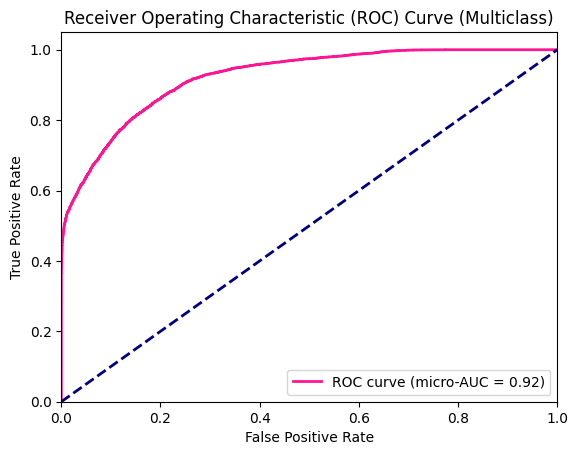

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Assuming model is already defined and moved to GPU if available

# Assuming transformer is defined

# Assuming test_loader is defined

y_score_list = []
y_true_list = []

# Evaluate model
model.eval()
for images, labels in test_loader:
    if torch.cuda.is_available():
        images = images.cuda()
        labels = labels.cuda()

    with torch.no_grad():
        y_score_batch = model(images)
    
    y_score_list.append(y_score_batch.cpu().numpy())
    y_true_list.append(labels.cpu().numpy())

y_score = np.vstack(y_score_list)
y_true = np.hstack(y_true_list)

# Binarize the ground truth labels
y_true_bin = label_binarize(y_true, classes=np.unique(y_true))

# Compute ROC curve and ROC area for each class
n_classes = y_score.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve
plt.figure()
plt.plot(fpr["micro"], tpr["micro"], color='deeppink', lw=2, label=f'ROC curve (micro-AUC = {roc_auc["micro"]:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (Multiclass)')
plt.legend(loc='lower right')
plt.show()